In [1]:
# Импорт базовых компонентов, обеспечивающих работу системы

from eolearn.core.eoworkflow import LinearWorkflow, Dependency
from eolearn.core.eodata import FeatureType

# from sentinelhub import BBox, CRS
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

%matplotlib inline
import numpy as np
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import rasterio as rio

from eolearn.core import SaveToDisk, LoadFromDisk, EOTask, EOPatch, OverwritePermission
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature, DEMWCSInput, S2L2AWCSInput, L8L1CWCSInput, ExportToTiff

Небольшой вводный экскурс сопровождающих имеющийся код, так как по собственному опыту могу сказать, что некоторые вещи не всегда очевидны, а наличие подсказок значительно ускоряет процесс первоначального входа

чтобы установить библиотеку eo-learn, строго желательно использовать обучающие материалы по ссылке:
https://github.com/sentinel-hub/eo-learn

Библиотеки, требующие предварительной сборки можно найти здесь:
https://www.lfd.uci.edu/~gohlke/pythonlibs/

Как настроить sentinelhub для корректной работы:
https://sentinelhub-py.readthedocs.io/en/latest/configure.html

Документация и примеры использования:
https://eo-learn.readthedocs.io/en/latest/index.html

Немного об используемых индексных показателях:
http://un-spider.org/es/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio

Статья, указанная в работе:
https://www.mdpi.com/2072-4292/10/11/1680

Формула для расчета и ссылки на литературные источники:
https://www.indexdatabase.de/db/i-single.php?id=53

In [2]:
# # reference time


# date_first_start = '2019-04-18'  - период для получения ближайшего безоблачного снимка, предшествовавшего пожару
# date_first_end = '2019-04-20'

# date_last_start = '2019-08-21'  - период для получения ближайшего безоблачного снимка, после пожара
# date_last_end = '2019-08-22'

In [3]:
# Реализация дополнительного функционала, расширяющего базовый
# Создание собственной задачи по расчету dNBR при помощи наследования от базового класса задач - EOTask

class NormalBurningRatio(EOTask):
    """
    NBR = (9 - 12)/(9 + 12)
    DNBR = NBR_2 - NBR_1
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]

        nbr = (band_a - band_b)/(band_a + band_b)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, nbr[..., np.newaxis])

        return eopatch  

In [4]:
# Временная заглушка, определяющая область обработки, реализуется через функционал библиотеки sentinelhub

roi_bbox = BBox(bbox=[27.48, 51.75, 27.57, 51.64], crs=CRS.WGS84)

In [5]:
# Определение задач, выполняемых рабочим процессом
# все задачи, кроме add_nbr, являются бызовым функционалом, реализованным eo-learn

layer = 'BANDS-S2-L1C'

custom_script = 'return [B04, B08, B08A, B09, B11, B12];'
input_task = S2L1CWCSInput(
    layer=layer,
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='20m', # resolution x
    resy='20m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

add_ndvi = S2L1CWCSInput(layer='NDVI')

# Определение задачи на основе ползовательского класса, описанного нами ранее
add_nbr = NormalBurningRatio('NBR', 'BANDS/3','BANDS/5')

tiff_location = './predicted_tiff_D'

add_dem = DEMWCSInput(layer='DEM')

#add_l2a = S2L2AWCSInput(layer='BANDS-S2-L2A')

add_sen2cor = AddSen2CorClassificationFeature('SCL', layer='BANDS-S2-L2A')

save = SaveToDisk('io_example', overwrite_permission=2, compress_level=1)

In [ ]:
# Ниже - выполнение процесса для пеиода предшествовавшего пожару
# 1. указание временного промежутка
# 2. Формирование линейного рабочего процесса из задач
# 3. выполнение сформированного рабочего процесса и сохранение результов в переменную result

# Пакет обладает базовым функционалом, позволяющим строить граф на основании рабочего процесса, для 
# более удобного зрительного восприятия 

In [6]:
%%time

time_interval = ('2019-04-18', '2019-04-19')
workflow = LinearWorkflow(input_task, add_ndvi, add_nbr, add_sen2cor, add_dem, save)

result = workflow.execute({input_task: {'bbox': roi_bbox, 'time_interval': time_interval},
            save: {'eopatch_folder': 'eopatch'}})

Wall time: 28.6 s


In [7]:
# экспорт результов в переменную eopatch
# экспортированные данные представляют собой особую структуру данных EOPatch - экземпляр базового класса EOPatch
# по своей сути очень похоже на внутренний формат ENVI, больше всего напоминает многоуровневый словарь, где значениями
# являются numpy массивы с обрабатываемыми данными

eopatch = result[save]
eopatch

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(1, 612, 310, 6), dtype=float32)
    NBR: numpy.ndarray(shape=(1, 612, 310, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(1, 612, 310, 1), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(1, 612, 310, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(1, 612, 310, 1), dtype=int32)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(612, 310, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-04-18', '2019-04-19')
  }
  bbox: BBox(((27.48, 51.64), (27.57, 51.75)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 4, 19, 9, 34, 38)]
)

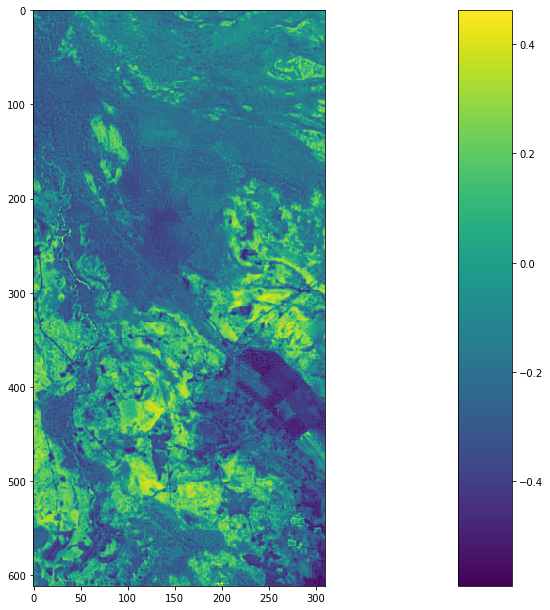

In [8]:
# простейший пример визуализации полученного индексного показателя

plt.figure(figsize=(10,10))
plt.imshow(eopatch.data['NBR'][0].squeeze());

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [ ]:
# Запуск рабочего процесса для даты после пожара

In [9]:
%%time

# time_interval = ('2019-05-31', '2019-06-09')
time_interval = ('2019-04-25', '2019-04-30')

workflow = LinearWorkflow(input_task, add_ndvi, add_nbr, add_sen2cor, add_dem, save)

result_new = workflow.execute({input_task: {'bbox': roi_bbox, 'time_interval': time_interval},
            save: {'eopatch_folder': 'eopatch'}})

Wall time: 20.3 s


In [10]:
eopatch_new = result_new[save]
eopatch_new

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(1, 612, 310, 6), dtype=float32)
    NBR: numpy.ndarray(shape=(1, 612, 310, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(1, 612, 310, 1), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(1, 612, 310, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(1, 612, 310, 1), dtype=int32)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(612, 310, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-04-25', '2019-04-30')
  }
  bbox: BBox(((27.48, 51.64), (27.57, 51.75)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 4, 26, 9, 32, 36)]
)

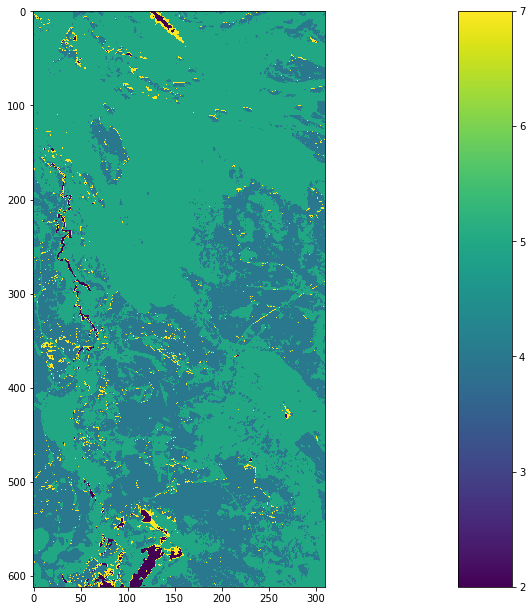

In [11]:
# Визуальный контроль облачности

plt.figure(figsize=(10,10))
plt.imshow(eopatch_new.mask['SCL'][0].squeeze());

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

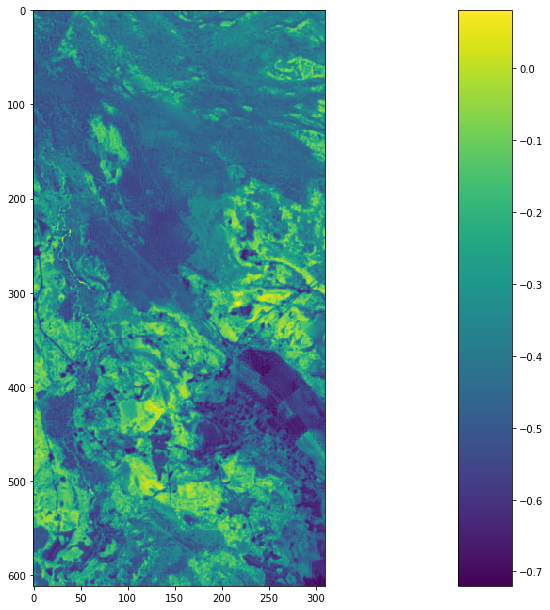

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(eopatch_new.data['NBR'][0].squeeze());

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [13]:
# Расчет dNBR в 2 вариантах (принципиальная разница лишь в знаке результата)

delta_nbr = eopatch.data['NBR'] - eopatch_new.data['NBR']
delta_nbr_1 = eopatch_new.data['NBR'] - eopatch.data['NBR']

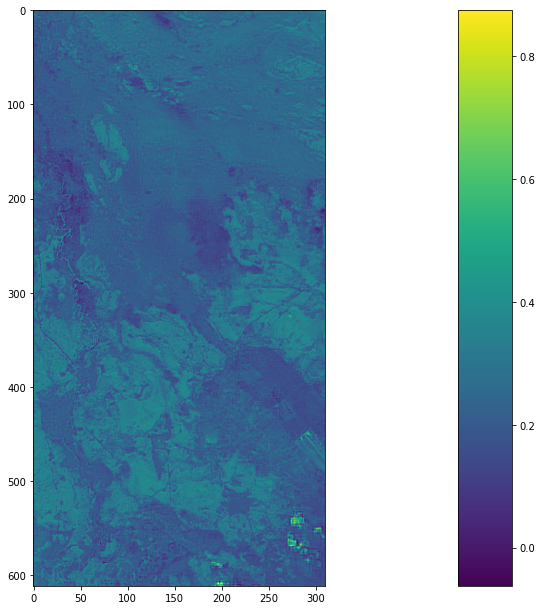

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(delta_nbr[0].squeeze());

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

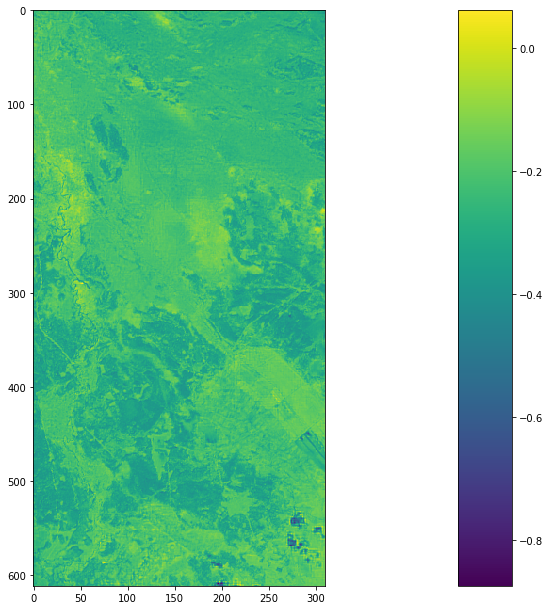

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(delta_nbr_1[0].squeeze());

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [16]:
result_patch = EOPatch()
result_patch[FeatureType.DATA]['dNBR'] = delta_nbr_1

In [17]:
result_patch

EOPatch(
  data: {
    dNBR: numpy.ndarray(shape=(1, 612, 310, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)

In [18]:
# Сохранение данных в папку .result_patch 

result_patch.save('./result_patch', overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

In [19]:
patch2 = EOPatch.load('./result_patch')

In [20]:
patch2

EOPatch(
  data: {
    dNBR: numpy.ndarray(shape=(1, 612, 310, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)